In [3]:
import pandas as pd
df_train = pd.read_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\processes_train.csv")  
df_test = pd.read_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\processes_test.csv")  
df_valid = pd.read_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\processes_valid.csv")

In [150]:
# ======================================================
# FeatureEngineering_simple.py
# Modular preprocessing for BETH dataset (IsolationForest friendly)
# ======================================================

import pandas as pd
import numpy as np
from sklearn.feature_extraction import FeatureHasher

# ------------------------------------------------------
# 1️⃣  单特征处理函数
# ------------------------------------------------------

def process_userId(df: pd.DataFrame) -> pd.Series:
    """userId: 二值化 + 保留外来账号强度"""
    if 'userId' not in df.columns:
        return pd.Series(0, index=df.index)
    s = df['userId']
    flag = (s >= 1000).astype(int)
    strength = np.where(s >= 1000, np.log1p(s - 999), 0)
    return pd.Series(flag, name="userId_flag"), pd.Series(strength, name="userId_log_strength")

def process_mountNamespace(df: pd.DataFrame) -> pd.Series:
    """mountNamespace: 是否等于常见值 4026531840"""
    if 'mountNamespace' not in df.columns:
        return pd.Series(0, index=df.index)
    return pd.Series((df['mountNamespace'] == 4026531840).astype(int), name="mountNamespace_flag")

def process_returnValue(df: pd.DataFrame) -> pd.Series:
    """returnValue: 三值化 (-1, 0, 1)"""
    if 'returnValue' not in df.columns:
        return pd.Series(0, index=df.index)
    s = df['returnValue'].fillna(0)
    mapped = s.apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
    return pd.Series(mapped, name="returnValue_mapped")

def process_argsNum(df: pd.DataFrame) -> pd.Series:
    """argsNum: 对数变换"""
    if 'argsNum' not in df.columns:
        return pd.Series(0, index=df.index)
    s = df['argsNum'].fillna(0)
    return pd.Series(np.log1p(s), name="argsNum_log")

def process_stackAddresses(df: pd.DataFrame) -> pd.Series:
    """stackAddresses: 栈深度（健壮解析 list/tuple/str）"""
    if 'stackAddresses' not in df.columns:
        return pd.Series(0, index=df.index)
    def count_depth(x):
        if isinstance(x, (list, tuple)):
            return len(x)
        if isinstance(x, str):
            s = x.strip()
            if not s:
                return 0
            seps = ['|', ',', ';']
            for sep in seps:
                if sep in s:
                    parts = [p for p in s.split(sep) if p]
                    return len(parts)
            return len(s.split())
        return 0
    depth = df['stackAddresses'].apply(count_depth)
    return pd.Series(np.log1p(depth), name="stack_depth_log")

def process_eventId(df: pd.DataFrame, n_features: int = 32) -> pd.DataFrame:
    """eventId: 哈希编码"""
    if 'eventId' not in df.columns:
        return pd.DataFrame(index=df.index)
    hasher = FeatureHasher(n_features=n_features, input_type='string')
    vec = hasher.transform(df['eventId'].astype(str).values.reshape(-1, 1))
    hashed = pd.DataFrame(vec.toarray(), index=df.index)
    hashed.columns = [f"eventId_hash_{i}" for i in range(n_features)]
    return hashed

def process_processName(df: pd.DataFrame, n_features: int = 32) -> pd.DataFrame:
    """processName: 哈希编码"""
    if 'processName' not in df.columns:
        return pd.DataFrame(index=df.index)
    hasher = FeatureHasher(n_features=n_features, input_type='string')
    vec = hasher.transform(df['processName'].astype(str).values.reshape(-1, 1))
    hashed = pd.DataFrame(vec.toarray(), index=df.index)
    hashed.columns = [f"processName_hash_{i}" for i in range(n_features)]
    return hashed

def process_eventName(df: pd.DataFrame, n_features: int = 32) -> pd.DataFrame:
    """eventName: 哈希编码"""
    if 'eventName' not in df.columns:
        return pd.DataFrame(index=df.index)
    hasher = FeatureHasher(n_features=n_features, input_type='string')
    vec = hasher.transform(df['eventName'].astype(str).values.reshape(-1, 1))
    hashed = pd.DataFrame(vec.toarray(), index=df.index)
    hashed.columns = [f"eventName_hash_{i}" for i in range(n_features)]
    return hashed

def process_parentProcessId(df: pd.DataFrame) -> pd.Series:
    """parentProcessId: 是否为系统级(0,1,2)"""
    if 'parentProcessId' not in df.columns:
        return pd.Series(0, index=df.index)
    return pd.Series(df['parentProcessId'].isin([0,1,2]).astype(int), name="parentPID_sys_flag")

def process_processId(df: pd.DataFrame) -> pd.Series:
    """processId: 是否为系统级(0,1,2)"""
    if 'processId' not in df.columns:
        return pd.Series(0, index=df.index)
    return pd.Series(df['processId'].isin([0,1,2]).astype(int), name="process_sys_flag")

def Wangprocess_someFeature(df: pd.DataFrame) -> pd.DataFrame:
    """
    自定义特征处理（返回 DataFrame，不会引入额外行）
    生成列：
      - eventId
      - argsNum
      - processId_is_os, parentProcessId_is_os, userId_is_os
      - mountNamespace_is_default
      - returnValue_mapped (-1/0/1)
    """
    out = pd.DataFrame(index=df.index)

    # 安全取列（缺失时填 0）
    # out["eventId"] = df["eventId"] if "eventId" in df.columns else 0
    #out["argsNum"] = df["argsNum"] if "argsNum" in df.columns else 0

    if "processId" in df.columns:
        out["processId_is_os"] = df["processId"].isin([0, 1, 2]).astype(int)
    else:
        out["processId_is_os"] = 0

    if "parentProcessId" in df.columns:
        out["parentProcessId_is_os"] = df["parentProcessId"].isin([0, 1, 2]).astype(int)
    else:
        out["parentProcessId_is_os"] = 0

    # if "userId" in df.columns:
    #     out["userId_is_os"] = (df["userId"] < 1000).astype(int)
    # else:
    #     out["userId_is_os"] = 0

    if "mountNamespace" in df.columns:
        out["mountNamespace_is_default"] = (df["mountNamespace"] == 4026531840).astype(int)
    else:
        out["mountNamespace_is_default"] = 0

    if "returnValue" in df.columns:
        rv = pd.to_numeric(df["returnValue"], errors="coerce").fillna(0)
        out["returnValue_mapped"] = np.select(
            [rv < 0, rv == 0, rv > 0],
            [-1, 0, 1],
            default=0
        )
    else:
        out["returnValue_mapped"] = 0

    # 统一数值类型 & 缺失填充
    for c in out.columns:
        out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0)

    # 可选：快速自检，确保行数不变
    # assert out.shape[0] == df.shape[0]

    return out


def process_timestamp(
    df: pd.DataFrame,
    group_col: str = "processId",
    cap_quantile: float = 0.99,
) -> pd.DataFrame:
    """
    生成与原版本一致的 5 个时间特征（不会产生额外行）：
      - ts_rel        : 组内相对首时刻 (>=0)
      - ts_rel_log    : log1p(ts_rel)
      - ts_rel01      : 组内 0~1 归一化（duration=0 时回退 0）
      - ts_delta      : 组内按时间排序后的相邻差分(>=0)
      - ts_delta_log  : log1p(ts_delta)
    额外修复点：
      - 先按 (group_col, timestamp) 稳定排序再 diff
      - 负差与无效值安全处理，P99 裁剪防爆点
      - 保持索引与行数完全一致
    """
    out = pd.DataFrame(index=df.index)
    if "timestamp" not in df.columns:
        # 保持接口：返回空DF，不报错
        return out

    ts = pd.to_numeric(df["timestamp"], errors="coerce")

    # === 组内 min/max（用于 ts_rel、ts_rel01） ===
    if group_col in df.columns:
        ts_min = df.groupby(group_col)["timestamp"].transform(
            lambda x: pd.to_numeric(x, errors="coerce").min()
        )
        ts_max = df.groupby(group_col)["timestamp"].transform(
            lambda x: pd.to_numeric(x, errors="coerce").max()
        )
    else:
        gmin, gmax = np.nanmin(ts.values), np.nanmax(ts.values)
        ts_min = pd.Series(gmin, index=df.index)
        ts_max = pd.Series(gmax, index=df.index)

    # 相对时间（>=0）
    ts_rel = (ts - pd.to_numeric(ts_min, errors="coerce")).clip(lower=0)

    # 温和裁剪（防止极端值影响 log 曲率）
    if ts_rel.notna().any():
        rel_cap = float(ts_rel.quantile(cap_quantile))
        if np.isfinite(rel_cap) and rel_cap > 0:
            ts_rel = ts_rel.clip(upper=rel_cap)

    # 0-1 归一化（duration=0 时回退 0）
    duration = (pd.to_numeric(ts_max, errors="coerce") -
                pd.to_numeric(ts_min, errors="coerce"))
    duration = duration.replace(0, np.nan)
    ts_rel01 = (ts_rel / duration).fillna(0.0).clip(0.0, 1.0)

    # === 组内相邻差分（先排序再 diff，恢复原顺序） ===
    if group_col in df.columns:
        tmp = df[[group_col]].copy()
        tmp["timestamp"] = ts
        tmp["_idx"] = df.index
        tmp = tmp.sort_values([group_col, "timestamp"], kind="mergesort")

        gaps = tmp.groupby(group_col)["timestamp"].diff().clip(lower=0).fillna(0.0)

        # 全局 P99 裁剪差分
        gap_cap = float(gaps.quantile(cap_quantile)) if len(gaps) else 0.0
        if np.isfinite(gap_cap) and gap_cap > 0:
            gaps = gaps.clip(upper=gap_cap)

        # 写回原索引
        ts_delta = pd.Series(0.0, index=df.index)
        ts_delta.loc[tmp["_idx"]] = gaps.values
    else:
        tmp = pd.DataFrame({"timestamp": ts, "_idx": df.index}).sort_values("timestamp", kind="mergesort")
        gaps = tmp["timestamp"].diff().clip(lower=0).fillna(0.0)
        gap_cap = float(gaps.quantile(cap_quantile)) if len(gaps) else 0.0
        if np.isfinite(gap_cap) and gap_cap > 0:
            gaps = gaps.clip(upper=gap_cap)
        ts_delta = pd.Series(0.0, index=df.index)
        ts_delta.loc[tmp["_idx"]] = gaps.values

    # === 组装输出（保持原列名与类型） ===
    # out["ts_rel"] = ts_rel.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    # out["ts_rel_log"] = np.log1p(out["ts_rel"]).replace([np.inf, -np.inf], 0.0).fillna(0.0)
    out["ts_rel01"] = ts_rel01.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # out["ts_delta"] = ts_delta.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    # out["ts_delta_log"] = np.log1p(out["ts_delta"]).replace([np.inf, -np.inf], 0.0).fillna(0.0)

    # 数值化保险
    for c in out.columns:
        out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0.0)

    return out




# ------------------------------------------------------
# 2️⃣  主控制函数
# ------------------------------------------------------

def preprocess(df: pd.DataFrame, n_hash_features: int = 32) -> pd.DataFrame:
    """
    主预处理函数：调用各单独特征函数，并拼接为模型可用 DataFrame。
    """

    feats = []

    # === 数值 / 二值类 ===
    uflag, ulog = process_userId(df)
    feats += [uflag, ulog,
              #process_mountNamespace(df),
              #process_returnValue(df),
              process_argsNum(df),
              process_stackAddresses(df),
              process_parentProcessId(df),
              process_processId(df)
              ]

    # === 类别哈希类 ===
    #feats.append(process_eventId(df, n_features=n_hash_features))
    #feats.append(process_processName(df, n_features=n_hash_features))
    #feats.append(process_eventName(df, n_features=n_hash_features))

    # === 自定义特征类 ===
    feats.append(Wangprocess_someFeature(df))

    # === 时间特征类 ===
    #feats.append(process_timestamp(df))


    # 拼接所有结果
    df_out = pd.concat(feats, axis=1)

    # 缺失值统一填 0
    df_out = df_out.fillna(0)

    # 只保留数值
    df_out = df_out.select_dtypes(include=[np.number])

    return df_out

# ------------------------------------------------------
# 3️⃣  示例
# ------------------------------------------------------
# if __name__ == "__main__":
#     df = pd.read_csv("BETH_subset.csv")  # 示例输入
#     df_feat = preprocess(df, n_hash_features=32)
#     print("✅ Preprocessed shape:", df_feat.shape)
#     print("✅ Columns sample:", df_feat.columns[:10].tolist())
#     df_feat.to_csv("BETH_features_ready.csv", index=False)


In [151]:
df_train_feat = preprocess(df_train, n_hash_features=32)
df_test_feat = preprocess(df_test, n_hash_features=32)
df_valid_feat = preprocess(df_valid, n_hash_features=32)

In [152]:
df_train_feat.shape
df_train_feat.head()

#df_train_feat.head().to_csv(r"D:\Project\MachineLearningAlgorithm\forestMachineLearning\data\df_train_feat_sample.csv", index=False)

,userId_flag,userId_log_strength,argsNum_log,stack_depth_log,parentPID_sys_flag,process_sys_flag,processId_is_os,parentProcessId_is_os,mountNamespace_is_default,returnValue_mapped
0,0,0.0,1.386294,1.386294,1,0,0,1,0,1
1,0,0.0,1.609438,1.098612,1,1,1,1,1,0
2,0,0.0,1.098612,0.693147,1,1,1,1,1,0
3,0,0.0,1.609438,1.098612,1,1,1,1,1,0
4,0,0.0,1.609438,0.693147,1,1,1,1,1,1


In [153]:
df_valid_feat.shape
df_valid_feat.head()

,userId_flag,userId_log_strength,argsNum_log,stack_depth_log,parentPID_sys_flag,process_sys_flag,processId_is_os,parentProcessId_is_os,mountNamespace_is_default,returnValue_mapped
0,0,0.0,1.386294,1.386294,1,0,0,1,0,1
1,0,0.0,0.693147,0.693147,1,1,1,1,1,0
2,0,0.0,1.098612,0.693147,1,0,0,1,0,0
3,0,0.0,0.693147,0.693147,1,0,0,1,0,0
4,0,0.0,1.609438,0.693147,1,0,0,1,0,0


In [154]:
df_test_feat.shape
df_test_feat.head()

,userId_flag,userId_log_strength,argsNum_log,stack_depth_log,parentPID_sys_flag,process_sys_flag,processId_is_os,parentProcessId_is_os,mountNamespace_is_default,returnValue_mapped
0,0,0.0,1.098612,0.693147,0,0,0,0,1,0
1,0,0.0,0.693147,1.098612,0,0,0,0,1,0
2,0,0.0,0.693147,0.693147,1,1,1,1,1,0
3,0,0.0,0.693147,0.693147,0,0,0,0,1,0
4,0,0.0,1.609438,0.693147,0,0,0,0,1,1


In [155]:
# 保存 Id 列
test_ids = df_test["Id"].copy()  
test_ids.head()

0    0
1    1
2    2
3    3
4    4
Name: Id, dtype: int64

In [156]:
from sklearn.ensemble import IsolationForest
# model = IsolationForest(
#     n_estimators=100,
#     contamination=0.005,
#     max_features=0.6,
#     max_samples=0.6,
#     random_state=42,
#     n_jobs=-1
# )
model = IsolationForest(
    n_estimators=150,
    contamination=0.04,
    max_features=1.0,
    max_samples=20000,
    random_state=42,
    n_jobs=-1
)
model.fit(df_train_feat)

from sklearn.neighbors import LocalOutlierFactor
# ---------- 1) 训练 LOF ----------
# 重要：要在新数据上 predict，必须 novelty=True
# model = LocalOutlierFactor(
#     n_neighbors=35,        # 可调：20~50 常见
#     contamination=0.04,    # 只用于确定训练集阈值/offset
#     novelty=True,          # 允许对 valid/test 预测
#     metric="minkowski", p=2,
#     n_jobs=-1
# )
# print("Fitting LOF...")
# model.fit(df_train_feat)
# print("✅ LOF fitted.")

In [157]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, average_precision_score, precision_recall_fscore_support
# ========== 5. 模型评估 ==========
print("\nMaking predictions on validation data...")
y_valid_target = df_valid['target']

# 异常分数（越大越异常）
scores = -model.decision_function(df_valid_feat)
scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
# Average Precision
ap = average_precision_score(y_valid_target, scores_norm)
# 固定 percentile=97 计算 F1、P、R
thr = np.percentile(scores_norm, 97)
y_pred = (scores_norm >= thr).astype(int)
p, r, f1, _ = precision_recall_fscore_support(y_valid_target, y_pred, average="binary")

print("\nModel Evaluation:" + "precision: {:.4f}, recall: {:.4f}, F1-score: {:.4f}, AP: {:.4f}".format(p, r, f1, ap))
#print("Accuracy:", accuracy_score(y_valid_target, y_pred))
#print("\nConfusion Matrix:")
#print(confusion_matrix(y_valid_target, y_pred))
#print("\nClassification Report:")
#print(classification_report(y_valid_target, y_pred, zero_division=0))


Making predictions on validation data...

Model Evaluation:precision: 0.9951, recall: 0.7838, F1-score: 0.8769, AP: 0.9210


# test

In [158]:
# Evaluating combination 1/54: {'n_estimators': 100, 'max_samples': 0.6, 'max_features': 0.6, 'contamination': 0.005, 'random_state': 42}
# ========== 5. 模型测试 》》》 输出csv文件，提交kaggle ==========
print("\nMaking predictions on test data...")
# 手动设置阈值 percentile = 0.97
# === 3️⃣ 手动设置阈值 percentile = 97 ===
# === 2️⃣ 计算测试集异常分数 ===
score_test = -model.decision_function(df_test_feat)
# === 2️⃣ 将异常分数归一化到 [0, 1] ===
score_norm = (score_test - score_test.min()) / (score_test.max() - score_test.min())
# === 3️⃣ 构建提交 DataFrame ===
submission = pd.DataFrame({
    "Id": df_test["Id"],   # ⚠️ 必须与你的 processes_test.csv 中的 Id 对应
    "target": score_norm               # Kaggle 要求列名为 target
})

# === 4️⃣ 保存为 CSV 文件（无 index） ===
submission.to_csv("submission.csv", index=False)

print("✅ submission.csv 已生成，可直接上传至 Kaggle！")


Making predictions on test data...
✅ submission.csv 已生成，可直接上传至 Kaggle！


In [159]:
# # =========================
# # RFOD-style scoring block
# # 与 RFOD 完全一致的分数与归一化接口（最终强制在 [0,1]）
# # =========================
# import numpy as np
# import pandas as pd
# from typing import Optional, Dict

# # 1) 原始分数（越大越异常）：IsolationForest 用 -score_samples
# def iforest_raw_scores(model, X: pd.DataFrame) -> np.ndarray:
#     return -model.score_samples(X)  # 不做任何归一化/截断

# # 2) 在“参考集合”（通常用训练集）上拟合归一化统计量
# def get_norm_stats(scores: np.ndarray, method: str = "minmax") -> Dict:
#     s = np.asarray(scores, dtype=float)
#     if method == "minmax":
#         return {"method": "minmax", "min": float(s.min()), "max": float(s.max())}
#     elif method == "robust":
#         q25, q50, q75 = np.percentile(s, [25, 50, 75])
#         return {"method": "robust", "q25": float(q25), "q50": float(q50), "q75": float(q75)}
#     elif method in ("clip", "none"):
#         return {"method": method}
#     else:
#         raise ValueError(f"未知归一化方法: {method}")

# # 3) RFOD 四种归一化；若提供 ref_stats 则复用之；默认裁剪到 [0,1]
# def normalize_like_rfod(scores: np.ndarray,
#                         method: str = "minmax",
#                         ref_stats: Optional[Dict] = None,
#                         clip_to_unit: bool = True) -> np.ndarray:
#     s = np.asarray(scores, dtype=float)
#     eps = 1e-12

#     if method == "minmax":
#         if ref_stats and ref_stats.get("method") == "minmax":
#             smin, smax = ref_stats["min"], ref_stats["max"]
#         else:
#             smin, smax = float(s.min()), float(s.max())
#         out = (s - smin) / max(smax - smin, eps)

#     elif method == "robust":
#         if ref_stats and ref_stats.get("method") == "robust":
#             q25, q50, q75 = ref_stats["q25"], ref_stats["q50"], ref_stats["q75"]
#         else:
#             q25, q50, q75 = np.percentile(s, [25, 50, 75])
#         iqr = max(q75 - q25, eps)
#         z = (s - q50) / iqr
#         out = (z - z.min()) / max(z.max() - z.min(), eps)

#     elif method == "clip":
#         out = np.clip(s, 0.0, 1.0)

#     elif method == "none":
#         out = s

#     else:
#         raise ValueError(f"未知归一化方法: {method}")

#     if clip_to_unit:
#         before = out.copy()
#         out = np.clip(out, 0.0, 1.0)
#         clipped = int(np.sum((before < 0) | (before > 1)))
#         if clipped:
#             print(f"⚠️  已裁剪 {clipped}/{len(out)} 个分数到 [0,1] 区间 "
#                   f"({clipped/len(out)*100:.2f}%)")
#     return out

# # =========================
# # ↓ 用下面几行替换你的评估/导出段
# # 需要变量：
# #   - model: 训练好的 IsolationForest
# #   - df_train_feat, df_test_feat: 预处理后的特征
# #   - df_test: 原始测试集（含 'Id' 列）
# # =========================

# NORMALIZE_METHOD = "minmax"   # 可选: "minmax" | "robust" | "clip" | "none"
# USE_TRAIN_STATS  = True       # True: 用训练集统计量归一化（跨集可比，推荐）
# SUBMIT_PATH      = "submission.csv"

# print("\n# ========== 5. 模型测试 》》》 输出csv文件，提交kaggle ==========")

# # A) 在训练集上拟合归一化统计量（推荐）
# train_raw = iforest_raw_scores(model, df_train_feat)
# ref_stats = get_norm_stats(train_raw, method=NORMALIZE_METHOD) if USE_TRAIN_STATS else None

# # B) 计算测试集原始异常分数（越大越异常）
# test_raw = iforest_raw_scores(model, df_test_feat)
# print(f"原始分数范围: [{test_raw.min():.6f}, {test_raw.max():.6f}]  mean={test_raw.mean():.6f} std={test_raw.std():.6f}")

# # C) RFOD-style 归一化（最终强制在 [0,1]）
# test_scores = normalize_like_rfod(test_raw, method=NORMALIZE_METHOD, ref_stats=ref_stats, clip_to_unit=True)
# print(f"归一化方法: {NORMALIZE_METHOD}  -> 范围: [{test_scores.min():.6f}, {test_scores.max():.6f}]  (已保证在[0,1])")

# # D) 组装提交文件
# submission = pd.DataFrame({
#     "Id": df_test["Id"],
#     "target": test_scores
# })
# submission.to_csv(SUBMIT_PATH, index=False)
# print(f"✅ {SUBMIT_PATH} 已生成，可直接上传至 Kaggle！")


In [160]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import (
#     average_precision_score, 
#     precision_recall_fscore_support
# )
# from itertools import product

# # =============================
# # 参数网格定义
# # =============================
# param_grid = {
#     "n_estimators": [100, 200],
#     "max_samples": [0.6, 0.8, 1.0],
#     "max_features": [0.6, 0.8, 1.0],
#     "contamination": [0.005, 0.008, 0.015],
#     "random_state": [42]
# }

# # 展开网格为组合列表
# keys, values = zip(*param_grid.items())
# param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# # =============================
# # 定义评估函数
# # =============================
# def evaluate_isoforest(params, X_train, X_valid, y_valid, percentile=97):
#     """训练 IsolationForest 并返回验证集指标"""
#     model = IsolationForest(**params, n_jobs=-1)
#     model.fit(X_train)
    
#     # 异常分数（越大越异常）
#     scores = -model.decision_function(X_valid)
#     scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
    
#     # 平均精度 AP
#     ap = average_precision_score(y_valid, scores_norm)
    
#     # 固定分位数阈值，计算 Precision/Recall/F1
#     thr = np.percentile(scores_norm, percentile)
#     y_pred = (scores_norm >= thr).astype(int)
#     p, r, f1, _ = precision_recall_fscore_support(y_valid, y_pred, average="binary")
    
#     return {
#         "params": params,
#         "precision": p,
#         "recall": r,
#         "f1": f1,
#         "ap": ap
#     }

# # =============================
# # 主循环：网格搜索
# # =============================
# results = []

# for i, params in enumerate(param_combinations, 1):
#     print(f"▶ Evaluating combination {i}/{len(param_combinations)}: {params}")
#     metrics = evaluate_isoforest(params, df_train_feat, df_valid_feat, df_valid["target"])
#     results.append(metrics)
#     # ✅ 实时打印当前性能
#     print(f"[{i:02d}/{len(param_combinations)}] "
#           f"n_est={params['n_estimators']}, samp={params['max_samples']}, feat={params['max_features']}, cont={params['contamination']} "
#           f"→ P={metrics['precision']:.4f}, R={metrics['recall']:.4f}, F1={metrics['f1']:.4f}, AP={metrics['ap']:.4f}")

# # 转为 DataFrame
# results_df = pd.DataFrame(results)

# # =============================
# # 输出结果
# # =============================
# results_df = results_df.sort_values(by="f1", ascending=False).reset_index(drop=True)

# print("\n===== Grid Search Summary =====")
# print(results_df[["params", "precision", "recall", "f1", "ap"]])

# best_params = results_df.loc[0, "params"]
# print("\n✅ Best parameter combination:")
# for k, v in best_params.items():
#     print(f"  {k}: {v}")

# # =============================
# # 可视化 F1 对比（可选）
# # =============================
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 4))
# plt.plot(results_df["f1"].values, marker="o")
# plt.xlabel("Parameter combination index")
# plt.ylabel("F1 score")
# plt.title("IsolationForest Parameter Grid Search")
# plt.grid(True)
# plt.show()


In [161]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# 统一分数定义：越大越异常
scores = -model.decision_function(df_valid_feat)
y_valid_target = df_valid['target']
ap = average_precision_score(y_valid_target, scores)

prec, rec, thr = precision_recall_curve(y_valid_target, scores)

print(f"AP={ap:.4f},  MaxPrecision@AnyRecall={prec.max():.4f}")

# 看你固定97分位在曲线上的位置
p97 = np.percentile(scores, 97)
yp97 = (scores >= p97).astype(int)
from sklearn.metrics import precision_recall_fscore_support
P,R,F1,_ = precision_recall_fscore_support(y_valid_target, yp97, average="binary")
print(f"@97th → P={P:.4f}, R={R:.4f}, F1={F1:.4f}")


AP=0.9210,  MaxPrecision@AnyRecall=1.0000
@97th → P=0.9951, R=0.7838, F1=0.8769


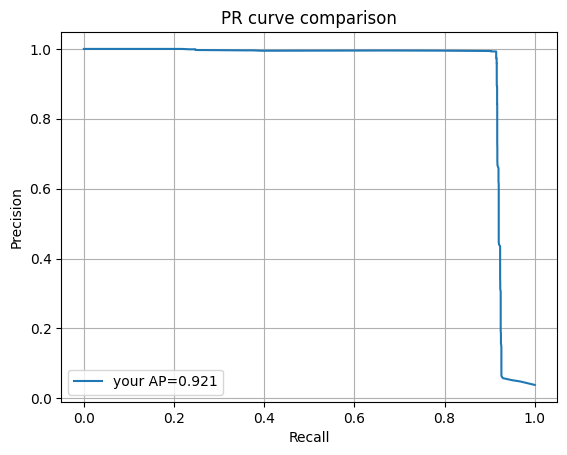

In [162]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# scores1 = -isoModel.decision_function(x_valid)     # 左模型
scores2 = -model.decision_function(df_valid_feat)  # 右模型
y = y_valid_target

# ap1 = average_precision_score(y, scores1)
ap2 = average_precision_score(y, scores2)

# print(f"AP1={ap1:.4f}, AP2={ap2:.4f}")

import matplotlib.pyplot as plt
# prec1, rec1, _ = precision_recall_curve(y, scores1)
prec2, rec2, _ = precision_recall_curve(y, scores2)
# plt.plot(rec1, prec1, label=f'ipynb AP={ap1:.3f}')
plt.plot(rec2, prec2, label=f'your AP={ap2:.3f}')
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.grid(True)
plt.title("PR curve comparison")
plt.show()